# Analyzing ClimateNet Dataset

In this notebook we analyze the ClimateNet dataset by computing several useful statistics and visualizing interesting examples.

In [1]:
from pathlib import Path

# specify the path to the data and output directories
out_dir = Path('/mnt/data/ai4good/out')
data_dir = Path('/mnt/data/ai4good/climatenet_new')  # expected to have a subfolder 'train' containing the train set
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

##  Data Exploration

First, we load the available train data and explore it a bit.

In [2]:
from utils.data import ClimateNetDataset
import xarray as xr
import numpy as np

ds = ClimateNetDataset(train_dir)

concat_ds = []
for i in np.random.randint(0, len(ds), 3):
    x = ds[i]
    concat_ds.append(x)

concat_ds = xr.concat(concat_ds, dim='time')

len(ds)
len(concat_ds)

17

In [3]:
sample = ds[0]
sample

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

In [4]:
sample.dims

Frozen({'lat': 768, 'lon': 1152, 'time': 1})

In [5]:
sample.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc'

In [6]:
for var in sample.data_vars:
    if var == 'LABELS':
        print(f'{var}: {sample[var].attrs["description"]} ({sample[var].dtype})')
    else:
        print(f'{var}: {sample[var].attrs["description"]} ({sample[var].attrs["units"]}) ({sample[var].dtype})')

TMQ: total (vertically integrated) precipitable water ( kg/m^2) (float32)
U850: zonal wind at 850 mbar pressure surface (m/s) (float32)
V850: meridional wind at 850 mbar pressure surface (m/s) (float32)
UBOT: lowest level zonal wind (m/s) (float32)
VBOT: lowest model level meridional wind (m/s) (float32)
QREFHT: reference height humidity (kg/kg) (float32)
PS: surface pressure (Pa) (float32)
PSL: sea level pressure (Pa) (float32)
T200: temperature at 200 mbar pressure surface (K) (float32)
T500: temperature at 500 mbar pressure surface (K) (float32)
PRECT: total (convective and large-scale) precipitation rate (liq + ice) (m/s) (float32)
TS: surface temperature (radiative) (K) (float32)
TREFHT: reference height temperature (K) (float32)
Z1000: geopotential Z at 1000 mbar pressure surface (m) (float32)
Z200: geopotential Z at 200 mbar pressure surface (m) (float32)
ZBOT: lowest modal level height (m) (float32)
LABELS: 0: Background, 1: Tropical Cyclone, 2: Athmospheric river (int64)


In [7]:
import ipywidgets as widgets
variables = list(sample.data_vars)
var_dropdown = widgets.Dropdown(options=variables, value=variables[0], description='Variable')

def plot_sample(var):
    sample[var].plot(figsize=(10,5))

widgets.interact(plot_sample, var=var_dropdown);

interactive(children=(Dropdown(description='Variable', options=('TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT…

## Data Analysis

import numpy as np

stats = {}

height = ds[0].dims['lat']
weight = ds[0].dims['lon']
data_vars = ds[0].data_vars
data_vars = ['TMQ']

for var in data_vars:
    stats[var] = {
        "mean": 0.0,
        "mean_grouped": np.array([0.0, 0.0, 0.0]),
        "mean_image": np.zeros((height, weight)),
    }

for i in np.random.randint(0, len(ds), 3):
    sample = ds[i]
    for var in data_vars:
        if var == 'LABELS':
            stats[var]["mean_image"] += sample[var].values
        else:
            stats[var]["mean_image"] += sample[var][0].values
            stats[var]["mean_grouped"] += sample[var][0].groupby(sample['LABELS']).mean().values.flatten()

for var in data_vars:
    #stats[var]["mean_image"] /= len(ds)
    stats[var]["mean"] = np.mean(stats[var]["mean_image"])
    #stats[var]["mean_grouped"] /= len(ds)

    print(f'{var}: mean={stats[var]["mean"]:.2f}, mean_grouped={stats[var]["mean_grouped"]}')


import matplotlib.pyplot as plt

plt.subplots(1, 1, figsize=(10,5))
plt.imshow(stats['TMQ']["mean_image"])
plt.colorbar()

In [8]:
ds[0]

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-1996-06-09-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

In [9]:
sample_1, sample_2 = ds[0].load(), ds[1].load()

In [10]:
import xarray as xr
tmq = sample_1['U850'].load()
tmqq = sample_2['U850'].load()
xr.corr(tmq, tmq, dim='time')

<xarray.DataArray 'U850' (lat: 768, lon: 1152)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

In [11]:
concat_ds.isel(time=0)

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
    time     <U23 'data-1996-09-01-01-1.nc'
Data variables: (12/17)
    TMQ      (lat, lon) float32 0.434 0.434 0.434 0.434 ... 11.23 11.23 11.23
    U850     (lat, lon) float32 -0.7734 -0.7537 -0.7339 ... 3.662 3.649 3.636
    V850     (lat, lon) float32 -3.617 -3.621 -3.626 ... -2.409 -2.429 -2.449
    UBOT     (lat, lon) float32 -0.7734 -0.7537 -0.7339 ... 1.649 1.647 1.645
    VBOT     (lat, lon) float32 -3.617 -3.621 -3.626 ... -0.4077 -0.4167 -0.4257
    QREFHT   (lat, lon) float32 7.014e-06 7.014e-06 ... 0.003252 0.003252
    ...       ...
    TS       (lat, lon) float32 211.2 211.2 211.2 211.2 ... 272.1 272.1 272.1
    TREFHT   (lat, lon) float32 210.9 210.9 210.9 210.9 ... 271.8 271.8 271.8
    Z1000    (lat, lon) float32 2.832e+03 2.832e+03 2.832e+03 ... 59.49 59.49
    Z200     (lat, lon) float32 1.048e+04 1.048e+04 ... 1.147e+04 1.147e+04
    ZBOT     (lat, lon) float32 46.06 46.06 46.06 46.06 ... 59.49 59.49 59.49
    LABELS   (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [12]:
xr.corr(concat_ds['TMQ'], concat_ds['TMQ'])

<xarray.DataArray 'TMQ' ()>
array(1.00220237)

In [13]:
ds[0].dims

Frozen({'lat': 768, 'lon': 1152, 'time': 1})

In [14]:
from utils.stats import Stats

stats = Stats(ds=ds)

TMQ
U850
V850
UBOT
VBOT
QREFHT
PS
PSL
T200
T500
PRECT
TS
TREFHT
Z1000
Z200
ZBOT
LABELS


In [15]:
cm = stats.get_corr_matrix()

In [16]:
stats.get_corr('TMQ', 'U850')

<xarray.DataArray ()>
array(-0.15930631)

In [17]:
ev = stats.get_eigenvalues(cm)

In [18]:
cm

array([[ 1.00187226e+00, -1.59306310e-01,  1.86599380e-04,
        -1.85030643e-01,  3.61929687e-02,  9.39720890e-01,
         4.13566486e-01,  2.06887092e-01,  4.98895129e-01,
         7.79864949e-01,  2.14680244e-01,  7.19434920e-01,
         7.35803388e-01, -3.73406167e-01,  7.77441967e-01,
         7.54568871e-01],
       [-1.59306310e-01,  1.00288352e+00, -3.47428705e-02,
         8.62422581e-01, -1.30574798e-01, -1.93222978e-01,
         9.28526531e-02, -1.06461748e-01, -1.19365817e-01,
        -2.22516834e-01,  2.60854939e-02, -3.44188027e-02,
        -3.62949139e-02, -1.23583699e-01, -2.10196213e-01,
        -5.39293411e-02],
       [ 1.86599380e-04, -3.47428705e-02,  1.00296307e+00,
         5.60150847e-02,  8.10004641e-01, -1.45194427e-02,
        -7.24505558e-02, -3.75689691e-03, -3.32618739e-02,
        -6.31753939e-02, -4.38187020e-02, -7.62073597e-02,
        -8.68361045e-02,  7.15302561e-02, -5.36085260e-02,
        -8.45094476e-02],
       [-1.85030643e-01,  8.62422581e

In [19]:
ev

array([7.60034519e+00, 2.16569212e+00, 1.76192782e+00, 1.18285289e+00,
       1.03926157e+00, 6.18466698e-01, 3.04207227e-01, 2.53795502e-01,
       1.85928080e-01, 1.29496988e-01, 7.58354662e-02, 4.62914940e-02,
       1.03698525e-02, 5.62036475e-04, 3.00366837e-03, 2.51357167e-03])

In [20]:
stats.ds['PRECT'].var(dim='time')

<xarray.DataArray 'PRECT' (lat: 768, lon: 1152)>
array([[5.0535065e-18, 5.0535065e-18, 5.0535065e-18, ..., 5.0535065e-18,
        5.0535065e-18, 5.0535065e-18],
       [7.9902123e-18, 8.0004040e-18, 8.0172107e-18, ..., 7.9704336e-18,
        7.9771867e-18, 7.9837413e-18],
       [9.0618174e-18, 9.0722001e-18, 8.9250563e-18, ..., 8.9587697e-18,
        9.0509664e-18, 9.0379425e-18],
       ...,
       [4.7084576e-16, 5.2631398e-16, 5.7349557e-16, ..., 5.1669116e-16,
        4.6018638e-16, 4.2509415e-16],
       [8.4983435e-16, 8.4825887e-16, 8.4085379e-16, ..., 8.4547509e-16,
        8.4598109e-16, 8.4868270e-16],
       [4.4012523e-17, 4.3068757e-17, 4.3998534e-17, ..., 4.4013556e-17,
        4.3998663e-17, 4.4013873e-17]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

In [21]:
stats.get_mean_grouped_by_label('TMQ')

<xarray.DataArray 'TMQ' (LABELS: 3)>
array([19.428991, 47.81162 , 24.758265], dtype=float32)
Coordinates:
  * LABELS   (LABELS) int64 0 1 2
Attributes:
    description:  total (vertically integrated) precipitable water
    units:         kg/m^2

In [22]:
stats.ds['TMQ'].groupby(stats.ds['LABELS']).mean()

<xarray.DataArray 'TMQ' (LABELS: 3)>
array([19.428991, 47.81162 , 24.758265], dtype=float32)
Coordinates:
  * LABELS   (LABELS) int64 0 1 2
Attributes:
    description:  total (vertically integrated) precipitable water
    units:         kg/m^2

In [28]:

stats.ds.isnull().sum().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables: (12/17)
    TMQ      int64 0
    U850     int64 0
    V850     int64 0
    UBOT     int64 0
    VBOT     int64 0
    QREFHT   int64 0
    ...       ...
    TS       int64 0
    TREFHT   int64 0
    Z1000    int64 0
    Z200     int64 0
    ZBOT     int64 0
    LABELS   int64 0>

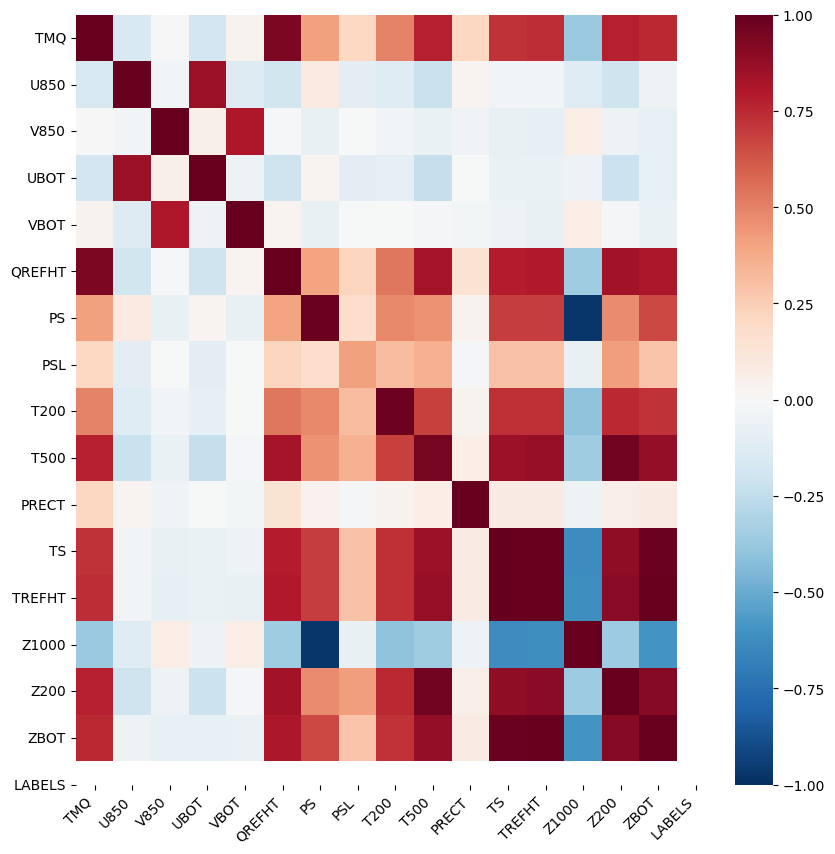

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, ax=ax, xticklabels=variables, yticklabels=variables, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
plt.show()